In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

# Transforms pour ResNet
transform_resnet = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


Tesla T4


In [8]:
# Dataset
from google.colab import drive
drive.mount('/content/drive')

# Unzip les dataset dans /tmp
!unzip -q "/content/drive/MyDrive/IA201/plant.zip" -d "/tmp/plant"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Script to split the dataset into training and testing sets
import os
import glob
import shutil
import numpy as np

train_path = '/tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
new_train_path = '/tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train'
new_test_path = new_train_path.replace('train', 'test')

subfolders = [ f.path for f in os.scandir(train_path) if f.is_dir() ]
test_percent = 0.2

for folder in sorted(subfolders):

    # For each subfolder, create a dictionary with the key as the image name
    # and the value as a list of all the filenames that contain that key
    filenames = sorted(glob.glob(os.path.join(folder, '*')))
    if 'Corn_(maize)___Common_rust_' in folder:
        keys = [f.split('/')[-1][:12] for f in filenames]
    else:
        keys = [f.split('/')[-1].split('_')[0] for f in filenames]
    keys = np.unique(keys)

    image_dict = {}

    # Create a dictionary with the key as the image name and the value as a list of all the filenames that contain that key
    for key in keys:
        image_dict[key] = []
        for filename in filenames:
            if key in filename:
                image_dict[key].append(filename)

    n_images = len(keys)
    print(f'There are {len(keys)} unique images in the folder {folder}')

    n_train = int(n_images * (1 - test_percent))
    n_test = n_images - n_train

    idx = np.arange(n_images)
    np.random.shuffle(idx)
    train_idx = idx[:n_train]
    test_idx = idx[n_train:]

    # Create the train and test folders
    train_folder = os.path.join(new_train_path, os.path.basename(folder))
    test_folder = os.path.join(new_test_path, os.path.basename(folder))
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    print(f'Creating {train_folder} and {test_folder}')
    # Copy the files to the train and test folders
    for i in train_idx:
        for filename in image_dict[keys[i]]:
            shutil.copy(filename, train_folder)
    for i in test_idx:
        for filename in image_dict[keys[i]]:
            shutil.copy(filename, test_folder)

# Copy the validation folder
# shutil.copytree('plants-disease-dataset/valid', 'new-plants-disease-dataset/valid')


old_train_filenames = sorted(glob.glob(os.path.join(train_path, '*/*')))
train_filenames = sorted(glob.glob(os.path.join(new_train_path, '*/*')))
test_filenames = sorted(glob.glob(os.path.join(new_test_path, '*/*')))

print('Before: train images:', len(old_train_filenames))
print('After: train images:', len(train_filenames))
print('After: test images:', len(test_filenames))

if len(old_train_filenames) != len(train_filenames) + len(test_filenames):
    print('Error: the number of images in the old train folder is not equal to the sum of the new train and test folders')
else:
    print('Success: the number of images in the old train folder is equal to the sum of the new train and test folders')

There are 630 unique images in the folder /tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab
Creating /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train/Apple___Apple_scab and /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/test/Apple___Apple_scab
There are 619 unique images in the folder /tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot
Creating /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train/Apple___Black_rot and /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/test/Apple___Black_rot
There are 275 unique images in the folder /tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust
Creating /tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train/Apple___Cedar_apple_rust and /tmp/plant/New Plant Diseases Dataset(Augmented

In [10]:
train_dataset = ImageFolder("/tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/train", transform=transform_resnet)
valid_dataset = ImageFolder("/tmp/plant/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid", transform=transform_resnet)
test_dataset = ImageFolder("/tmp/plant/New Plant Diseases Dataset(Augmented)/plants-dataset/test", transform=transform_resnet)

BATCH_SIZE = 128
NUM_WORKERS = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
# --- Bloc 1: Modèle CNN for 38 classes ---
class PlantCNN(nn.Module):
    def __init__(self, num_classes=38):
        super(PlantCNN, self).__init__()
        # 4 couches de conv + batch-norm + ReLU + maxpool
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Après 4× Pool: 128→64→32→16→8 ⇒ feature maps 256×8×8
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 128→64
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 64→32
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 32→16
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 16→8
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [13]:
net = PlantCNN(num_classes=38).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

In [ ]:
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss   = float('inf')
patience        = 3
patience_counter = 0

for epoch in range(1, num_epochs + 1):
    # ---- Entraînement ----
    net.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    epoch_loss = running_loss / running_total
    epoch_acc  = 100 * running_correct / running_total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ---- Validation ----
    net.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / val_total)
    val_accs.append(100 * val_correct / val_total)

    print(f'Epoch {epoch:2d}/{num_epochs} '
          f'Train: loss={epoch_loss:.3f} acc={epoch_acc:.1f}% | '
          f'Val: loss={val_losses[-1]:.3f} acc={val_accs[-1]:.1f}%')

        # --- Early stopping ---
    if val_losses[-1] < best_val_loss:
        best_val_loss    = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break



NameError: name 'time' is not defined

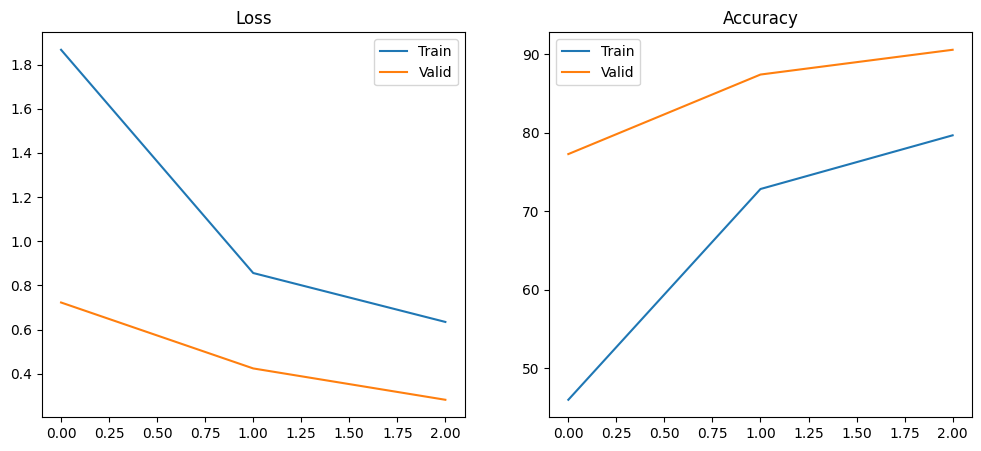

In [ ]:
# --- Bloc 4: Affichage des courbes ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses,   label='Val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accs,  marker='o', label='Train')
plt.plot(range(1, num_epochs+1), val_accs,    marker='o', label='Val')
plt.title("Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# --- Bloc 5: Évaluation finale + matrice de confusion ---
net.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Rapport de classification
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=train_dataset.classes)
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix – Test Set")
plt.show()

Test Accuracy: 91.36%


TypeError: ConfusionMatrixDisplay.plot() got an unexpected keyword argument 'figsize'